# Get started

In [1]:
# Imports
import os
from shutil import copy2
import urllib.request
from zipfile import ZipFile

import forestatrisk as far

# ForestAtRisk: Modelling and forecasting deforestation in the tropics.
# https://ecology.ghislainv.fr/forestatrisk/


We create a directory to hold the outputs with the help of the function `.make_dir()`.

In [2]:
# Make output directory
far.make_dir("output")

## 1. Data

### 1.1 Import and unzip the data

We use the [Guadeloupe](https://en.wikipedia.org/wiki/Guadeloupe) archipelago as a case study.

In [3]:
# Source of the data
url = "https://github.com/ghislainv/forestatrisk/raw/master/docsrc/notebooks/data_GLP.zip"

if os.path.exists("data_GLP.zip") is False:
    urllib.request.urlretrieve(url, "data_GLP.zip")

with ZipFile("data_GLP.zip", "r") as z:
    z.extractall("data")

### 1.2 Files

The `data` folder includes, among other files:

- The forest cover change data for the period 2010-2020 as a GeoTiff raster file (`data/fcc23.tif`).
- Spatial variables as GeoTiff raster files (`.tif` extension, eg. `data/dist_edge.tif` for distance to forest edge).

### 1.3 Sampling the observations



In [4]:
# Sample points
dataset = far.sample(nsamp=10000, adapt=True, seed=1234, csize=10,
                     var_dir="data",
                     input_forest_raster="fcc23.tif",
                     output_file="output/sample.txt",
                     blk_rows=0)

Sample 2x 10000 pixels (deforested vs. forest)
Divide region in 168 blocks
Compute number of deforested and forest pixels per block
100%
Draw blocks at random
Draw pixels at random in blocks
100%
Compute center of pixel coordinates
Compute number of 10 x 10 km spatial cells
... 99 cells (9 x 11)
Identify cell number from XY coordinates
Make virtual raster with variables as raster bands
Extract raster values for selected pixels
100%
Export results to file output/sample.txt


In [5]:
# Remove NA from data-set (otherwise scale() and
# model_binomial_iCAR doesn't work)
dataset = dataset.dropna(axis=0)
# Set number of trials to one for far.model_binomial_iCAR()
dataset["trial"] = 1
# Print the first five rows
print(dataset.head(5))

   altitude  dist_defor  dist_edge  dist_river  dist_road  dist_town  fcc23  \
0      30.0       642.0       30.0      8448.0     1485.0     6364.0    0.0   
1      37.0       765.0       30.0      8583.0     1697.0     6576.0    0.0   
2      78.0       216.0       30.0      7722.0      949.0     5743.0    0.0   
3      80.0       277.0       30.0      8168.0     1172.0     6047.0    0.0   
4      46.0        30.0       30.0      6179.0      541.0     6690.0    0.0   

    pa  slope          X          Y  cell  trial  
0  0.0    8.0 -6842295.0  1851975.0   4.0      1  
1  0.0    7.0 -6842235.0  1852095.0   4.0      1  
2  0.0    5.0 -6842535.0  1851195.0   4.0      1  
3  0.0    2.0 -6842445.0  1851615.0   4.0      1  
4  0.0    1.0 -6840465.0  1849755.0   4.0      1  


## 2. Model

### 2.1 Model preparation

In [6]:
# Neighborhood for spatial-autocorrelation
nneigh, adj = far.cellneigh(raster="data/fcc23.tif", csize=10, rank=1)

# List of variables
variables = ["scale(altitude)", "scale(slope)",
             "scale(dist_defor)", "scale(dist_edge)", "scale(dist_road)",
             "scale(dist_town)", "scale(dist_river)"]

# Formula
right_part = " + ".join(variables) + " + cell"
left_part = "I(1-fcc23) + trial ~ "
formula = left_part + right_part

# Starting values
beta_start = -99  # Simple GLM estimates

# Priors
priorVrho = -1  # -1="1/Gamma"

Compute number of 10 x 10 km spatial cells
... 99 cells (9 x 11)
Identify adjacent cells and compute number of neighbors


### 2.3 iCAR model

In [7]:
# Re-run the model with longer MCMC and estimated initial values
mod_binomial_iCAR = far.model_binomial_iCAR(
    # Observations
    suitability_formula=formula, data=dataset,
    # Spatial structure
    n_neighbors=nneigh, neighbors=adj,
    # Priors
    priorVrho=priorVrho,
    # Chains
    burnin=1000, mcmc=1000, thin=1,
    # Starting values
    beta_start=-99)

Using estimates from classic logistic regression as starting values for betas


### 2.4 Model summary

In [8]:
# Predictions
pred_icar = mod_binomial_iCAR.theta_pred

# Summary
print(mod_binomial_iCAR)
# Write summary in file
with open("output/summary_hSDM.txt", "w") as f:
    f.write(str(mod_binomial_iCAR))

Binomial logistic regression with iCAR process
  Model: I(1 - fcc23) + trial ~ 1 + scale(altitude) + scale(slope) + scale(dist_defor) + scale(dist_edge) + scale(dist_road) + scale(dist_town) + scale(dist_river) + cell
  Posteriors:
                        Mean        Std     CI_low    CI_high
        Intercept      -3.84      0.224      -4.23      -3.27
  scale(altitude)       -0.5      0.105     -0.679     -0.293
     scale(slope)    -0.0159     0.0545     -0.117     0.0906
scale(dist_defor)      -2.06      0.274      -2.51      -1.51
 scale(dist_edge)      -6.89       0.44      -7.78       -6.2
 scale(dist_road)    -0.0408     0.0573     -0.159     0.0702
 scale(dist_town)    -0.0916     0.0444     -0.175     0.0032
scale(dist_river)    -0.0122     0.0347    -0.0838     0.0607
             Vrho       3.12      0.852       1.83       5.07
         Deviance   1.52e+04         48   1.52e+04   1.54e+04



## 3. Predict

### 3.1 Interpolate spatial random effects

In [9]:
# Spatial random effects
rho = mod_binomial_iCAR.rho

# Interpolate
far.interpolate_rho(rho=rho, input_raster="data/fcc23.tif",
                    output_file="output/rho.tif",
                    csize_orig=10, csize_new=1)

Write spatial random effect data to disk
Compute statistics
Build overview
Resampling spatial random effects to file output/rho.tif


### 3.2 Predict deforestation probability

In [10]:
# Update dist_edge and dist_defor at t3
os.rename("data/dist_edge.tif", "data/dist_edge.tif.bak")
os.rename("data/dist_defor.tif", "data/dist_defor.tif.bak")
copy2("data/forecast/dist_edge_forecast.tif", "data/dist_edge.tif")
copy2("data/forecast/dist_defor_forecast.tif", "data/dist_defor.tif")

# Compute predictions
far.predict_raster_binomial_iCAR(
    mod_binomial_iCAR, var_dir="data",
    input_cell_raster="output/rho.tif",
    input_forest_raster="data/forest/forest_t3.tif",
    output_file="output/prob.tif",
    blk_rows=10  # Reduced number of lines to avoid memory problems
)

# Reinitialize data
os.remove("data/dist_edge.tif")
os.remove("data/dist_defor.tif")
os.rename("data/dist_edge.tif.bak", "data/dist_edge.tif")
os.rename("data/dist_defor.tif.bak", "data/dist_defor.tif")

Make virtual raster with variables as raster bands
Divide region in 296 blocks
Create a raster file on disk for projections
Predict deforestation probability by block
100%
Compute statistics


## 4. Project future forest cover change

In [11]:
# Forest cover
fc = list()
dates = ["t2", "t3"]
ndates = len(dates)
for i in range(ndates):
    rast = "data/forest/forest_" + dates[i] + ".tif"
    val = far.countpix(input_raster=rast, value=1)
    fc.append(val["area"])  # area in ha
# Save results to disk
f = open("output/forest_cover.txt", "w")
for i in fc:
    f.write(str(i) + "\n")
f.close()
# Annual deforestation
T = 10.0
annual_defor = (fc[0] - fc[1]) / T
print("Mean annual deforested area during the period 2020-2030: {} ha/yr".format(annual_defor))

Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Mean annual deforested area during the period 2020-2030: 498.375 ha/yr


In [12]:
# Projected deforestation (ha) during 2020-2050
defor = annual_defor * 30

# Compute future forest cover in 2050
stats = far.deforest(
    input_raster="output/prob.tif",
    hectares=defor,
    output_file="output/fcc_2050.tif",
    blk_rows=128)

Divide region in 24 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statistics


## 5. Figures

### 5.1 Historical forest cover change

Forest cover change for the period 2000-2010-2020

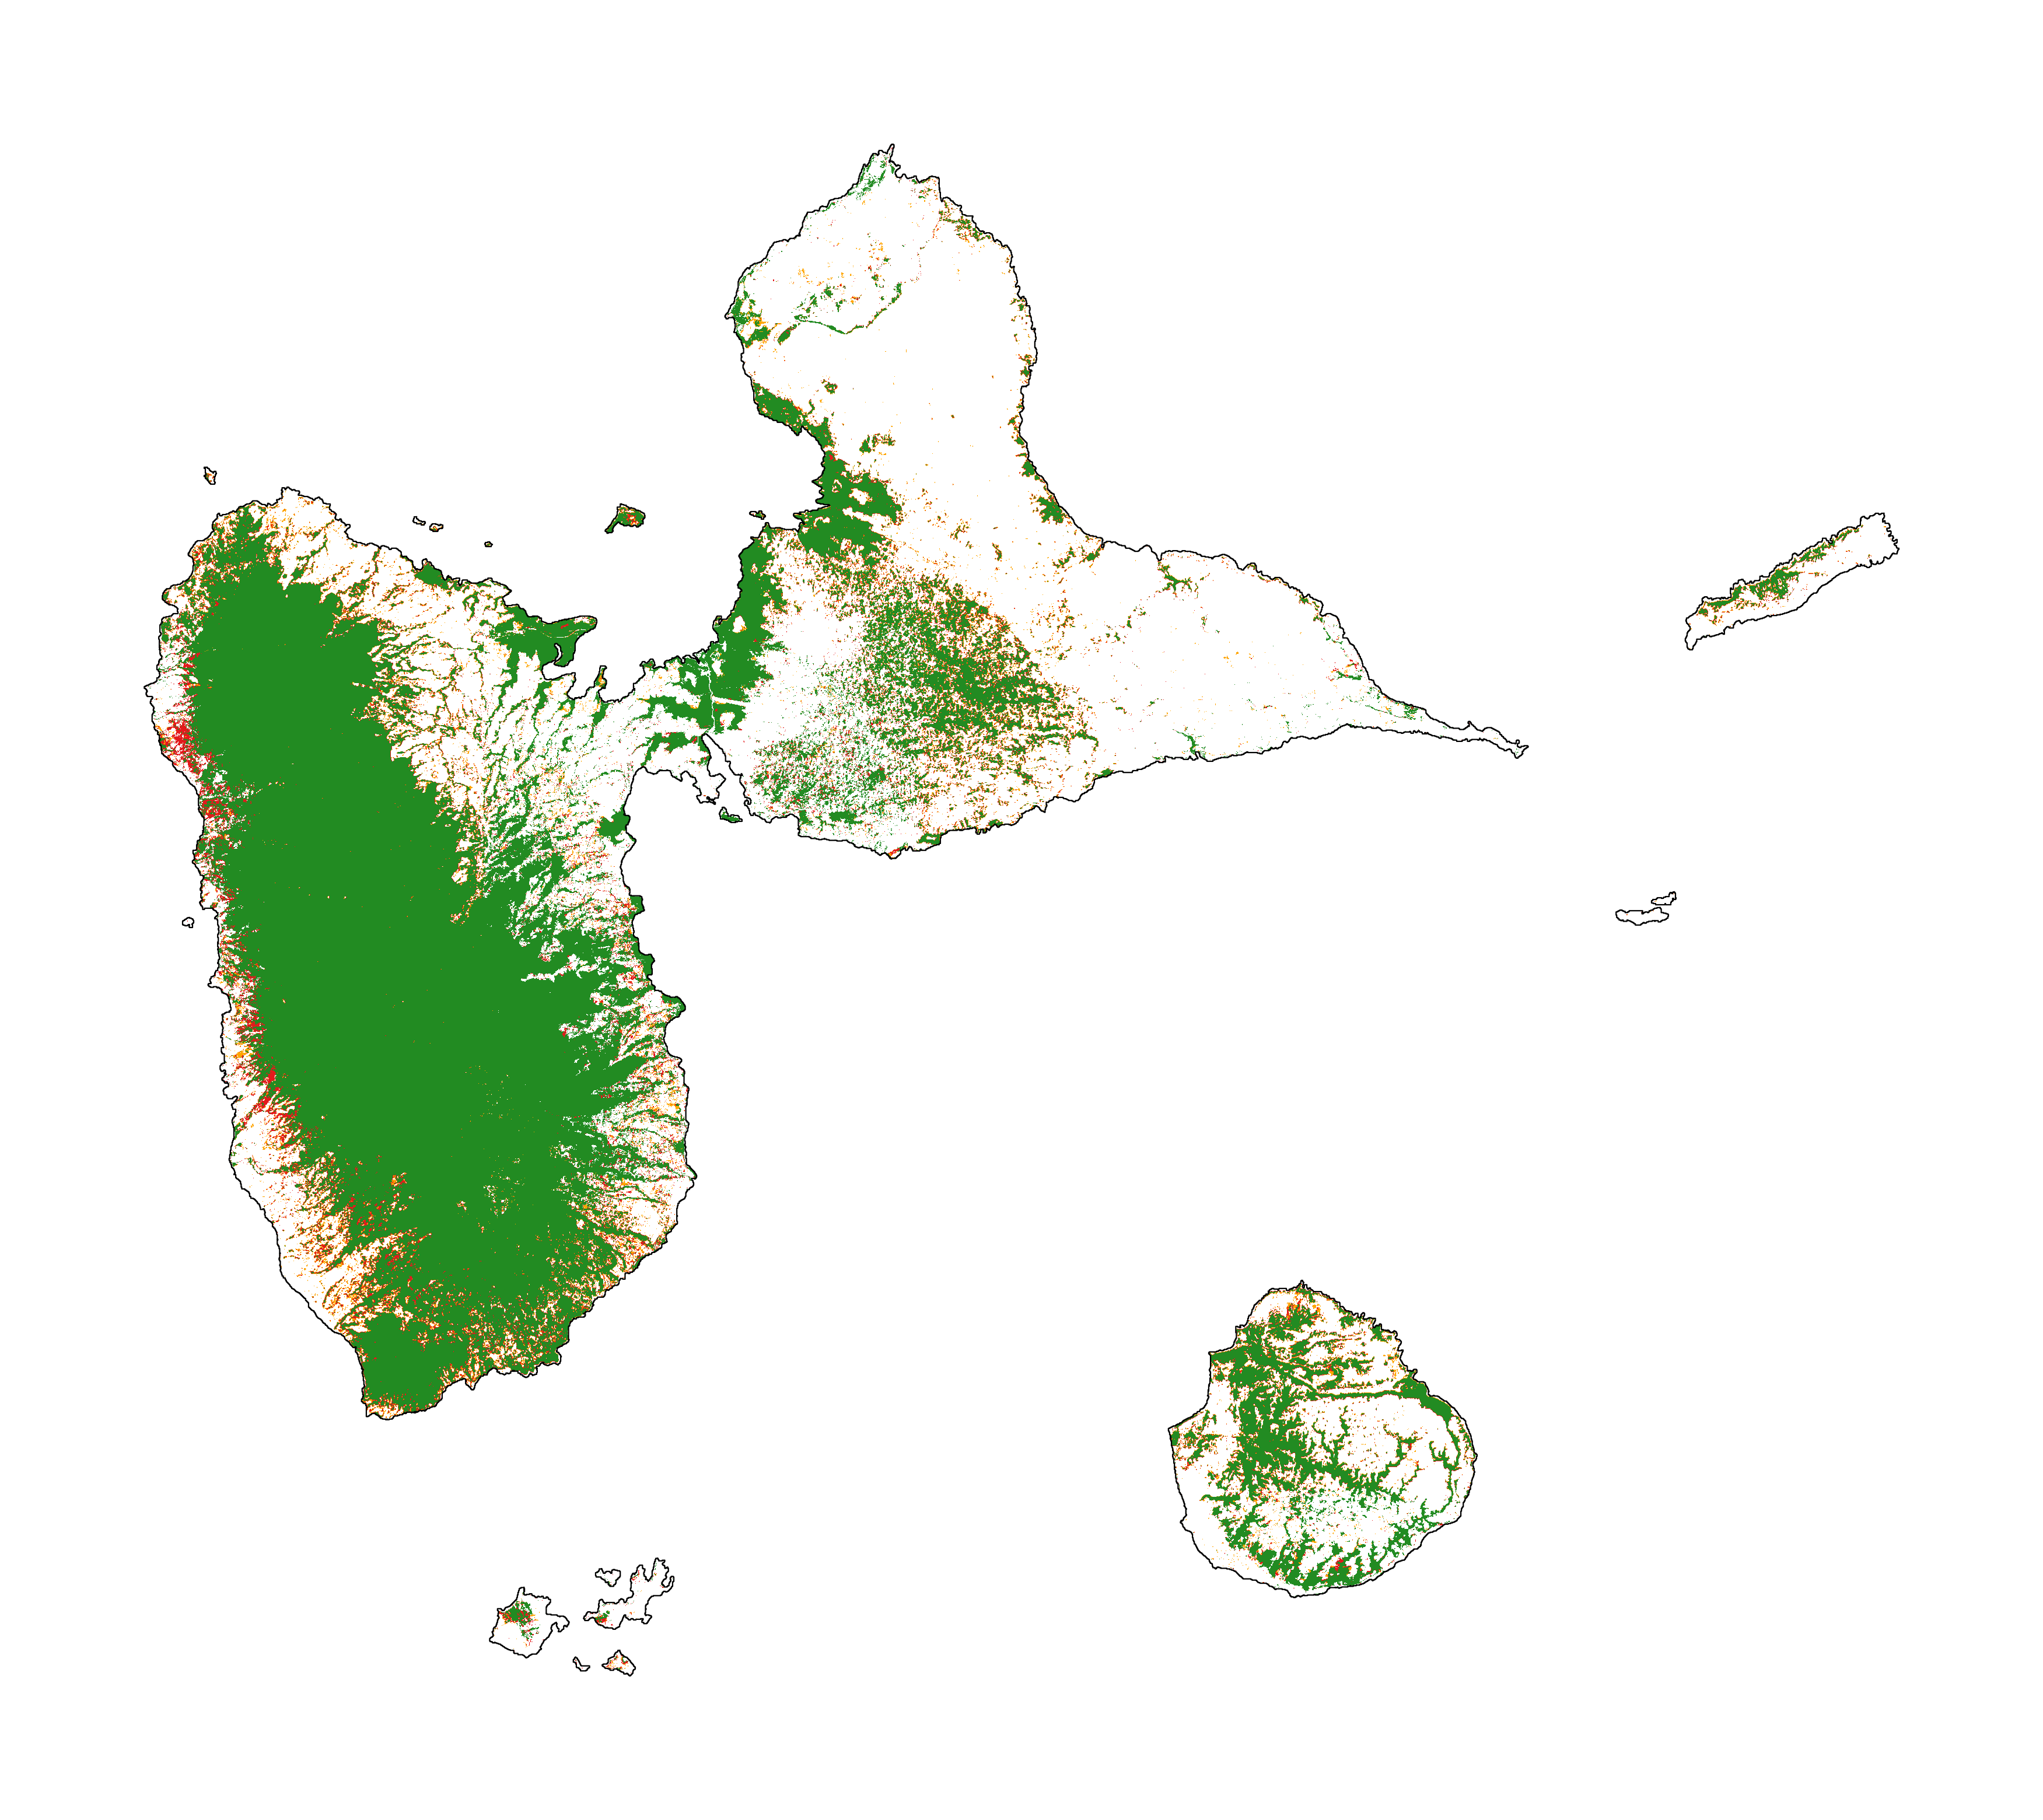

In [13]:
# Plot forest
fig_fcc123 = far.plot.fcc123(
    input_fcc_raster="data/forest/fcc123.tif",
    maxpixels=1e8,
    output_file="output/fcc123.png",
    borders="data/ctry_PROJ.shp",
    linewidth=0.2,
    figsize=(5, 4), dpi=800)

### 5.2 Spatial random effects

Build overview


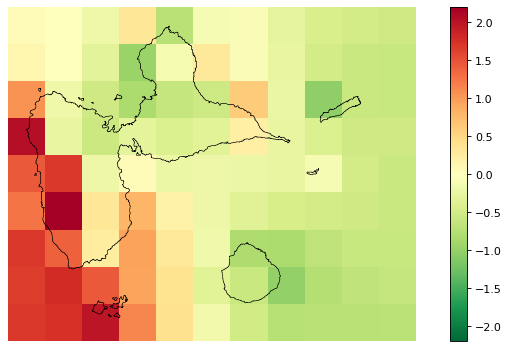

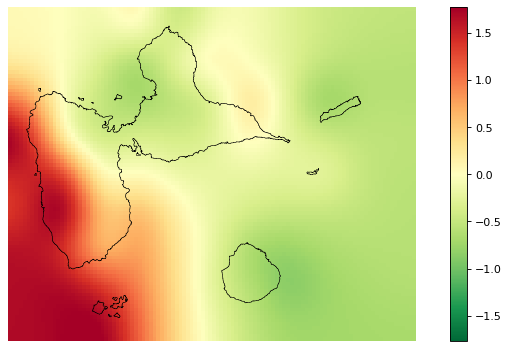

In [14]:
# Original spatial random effects
fig_rho_orig = far.plot.rho("output/rho_orig.tif",
                            borders="data/ctry_PROJ.shp",
                            linewidth=0.5,
                            output_file="output/rho_orig.png",
                            figsize=(9,5), dpi=80)

# Interpolated spatial random effects
fig_rho = far.plot.rho("output/rho.tif",
                       borders="data/ctry_PROJ.shp",
                       linewidth=0.5,
                       output_file="output/rho.png",
                       figsize=(9,5), dpi=80)

### 5.3 Spatial probability of deforestation

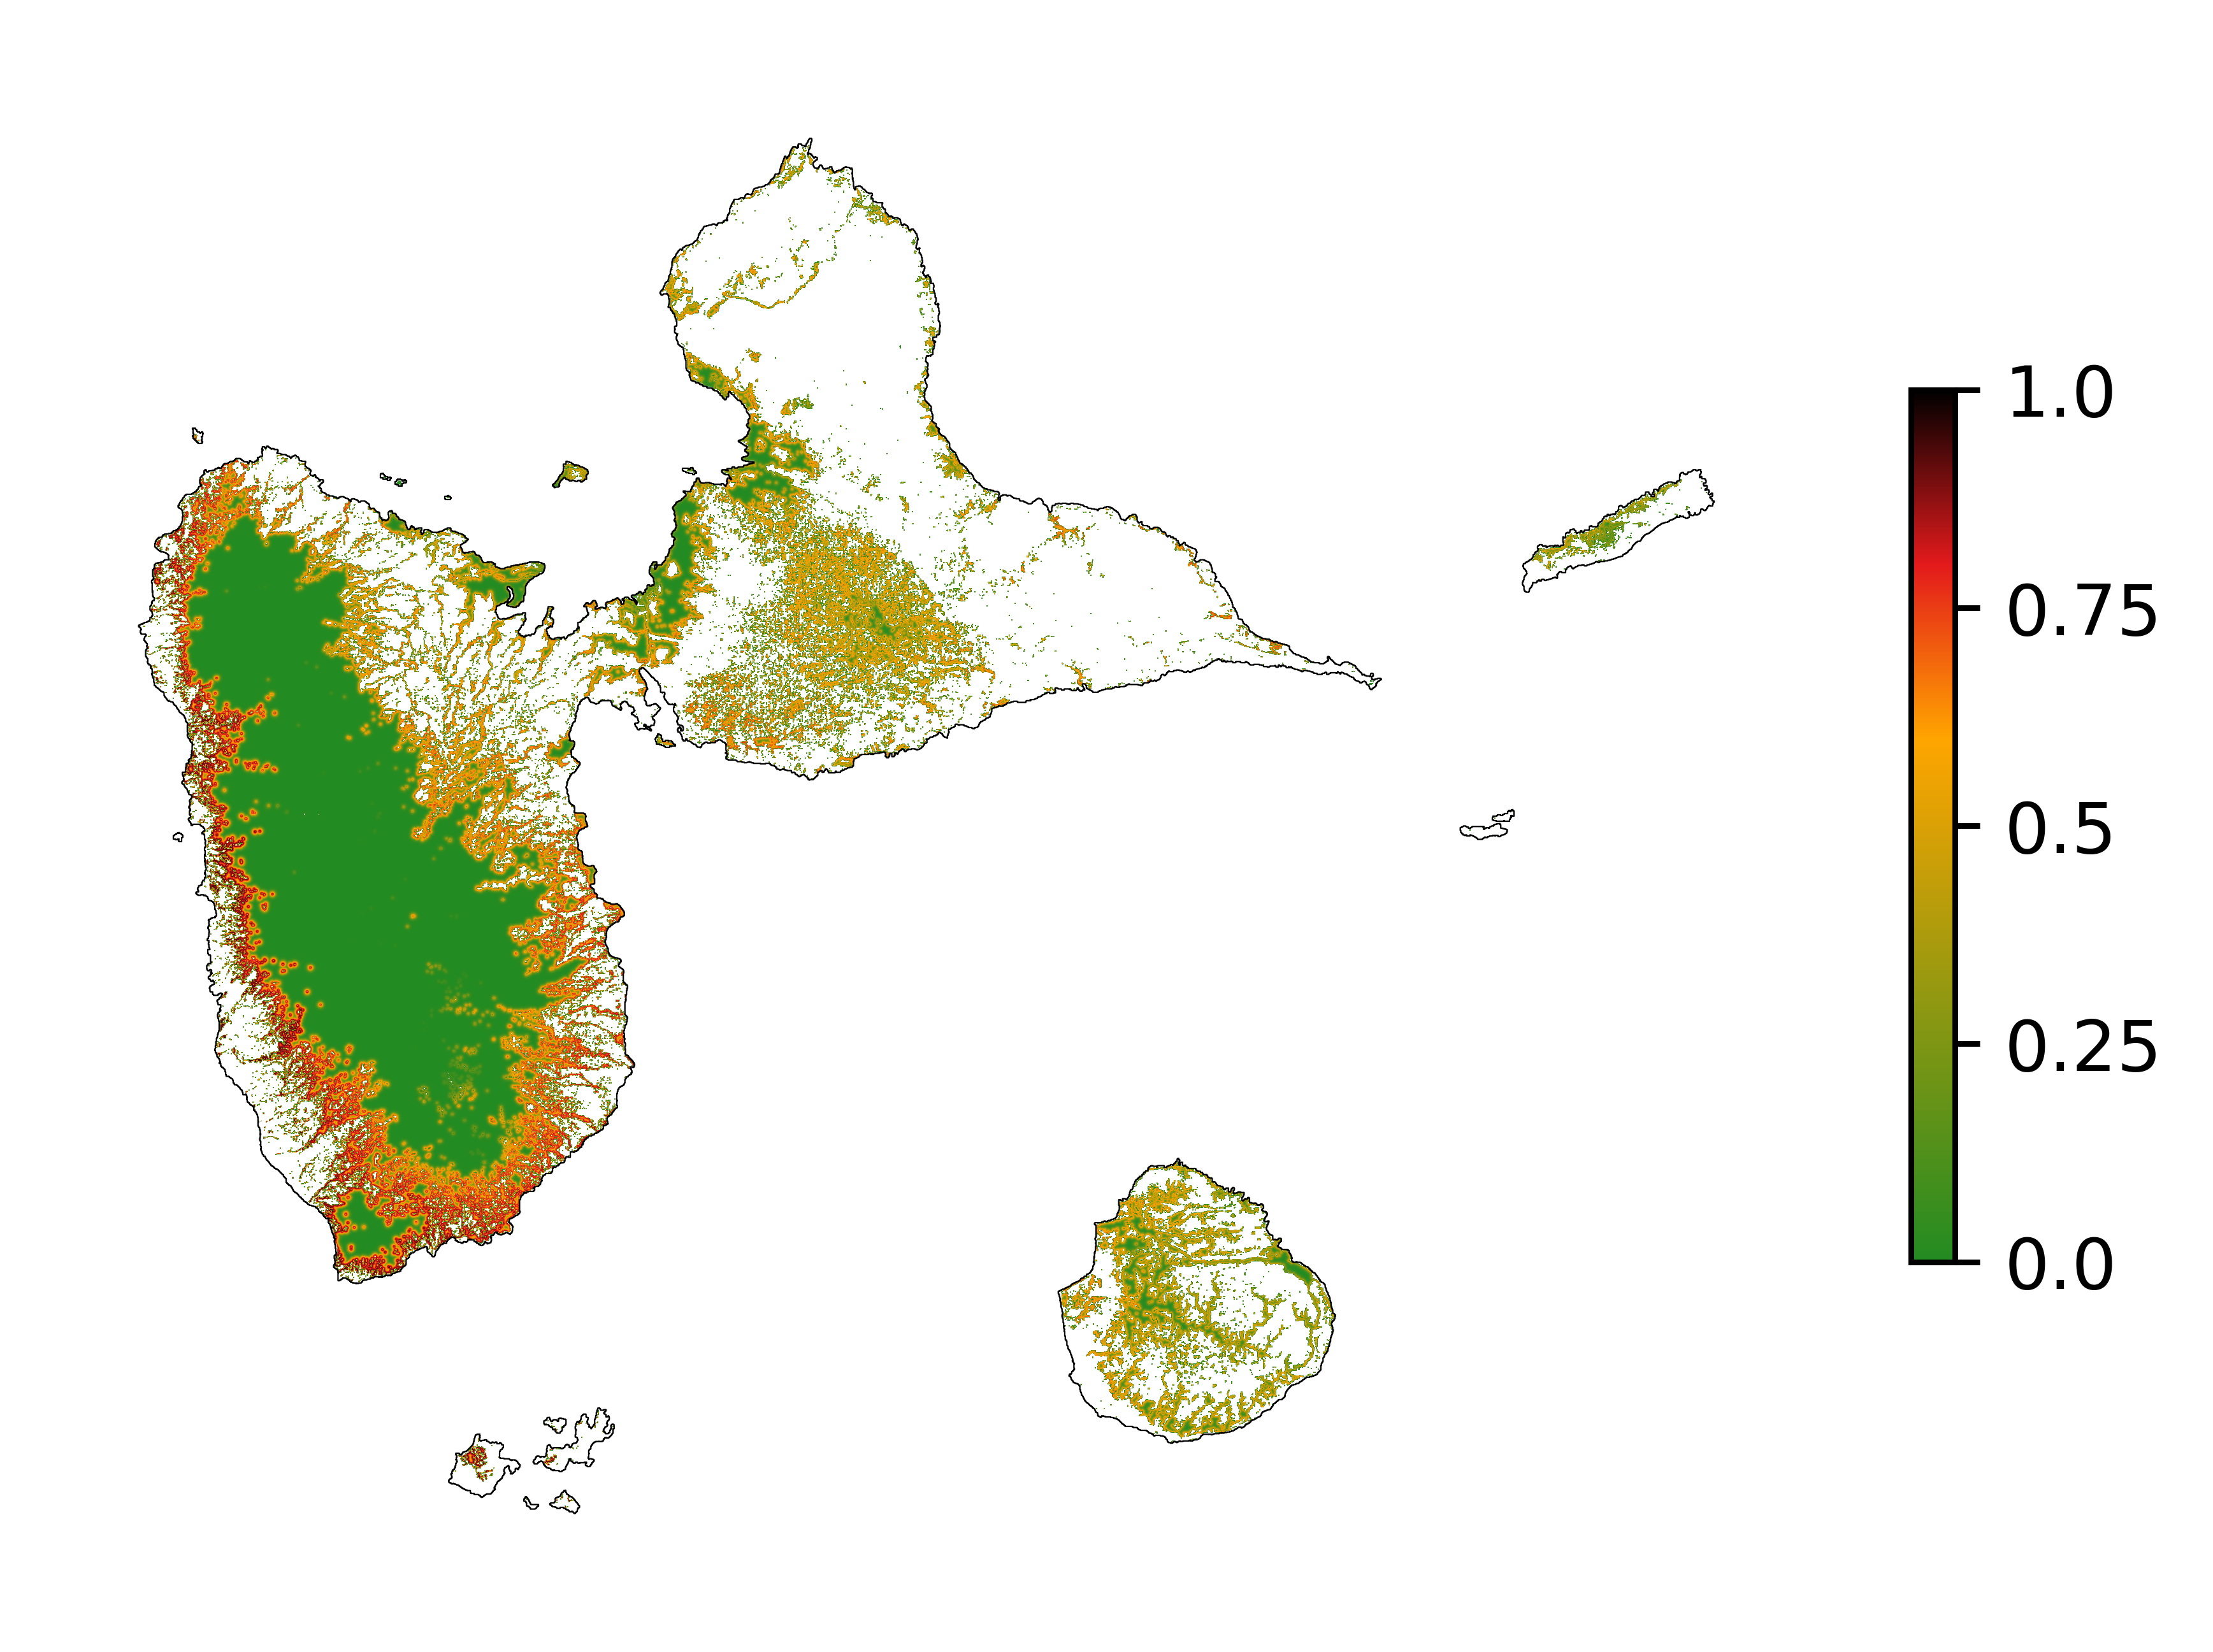

In [15]:
# Spatial probability of deforestation
fig_prob = far.plot.prob("output/prob.tif",
                         maxpixels=1e8,
                         borders="data/ctry_PROJ.shp",
                         linewidth=0.2,
                         legend=True,
                         output_file="output/prob.png",
                         figsize=(5, 4), dpi=800)

### 5.4 Future forest cover

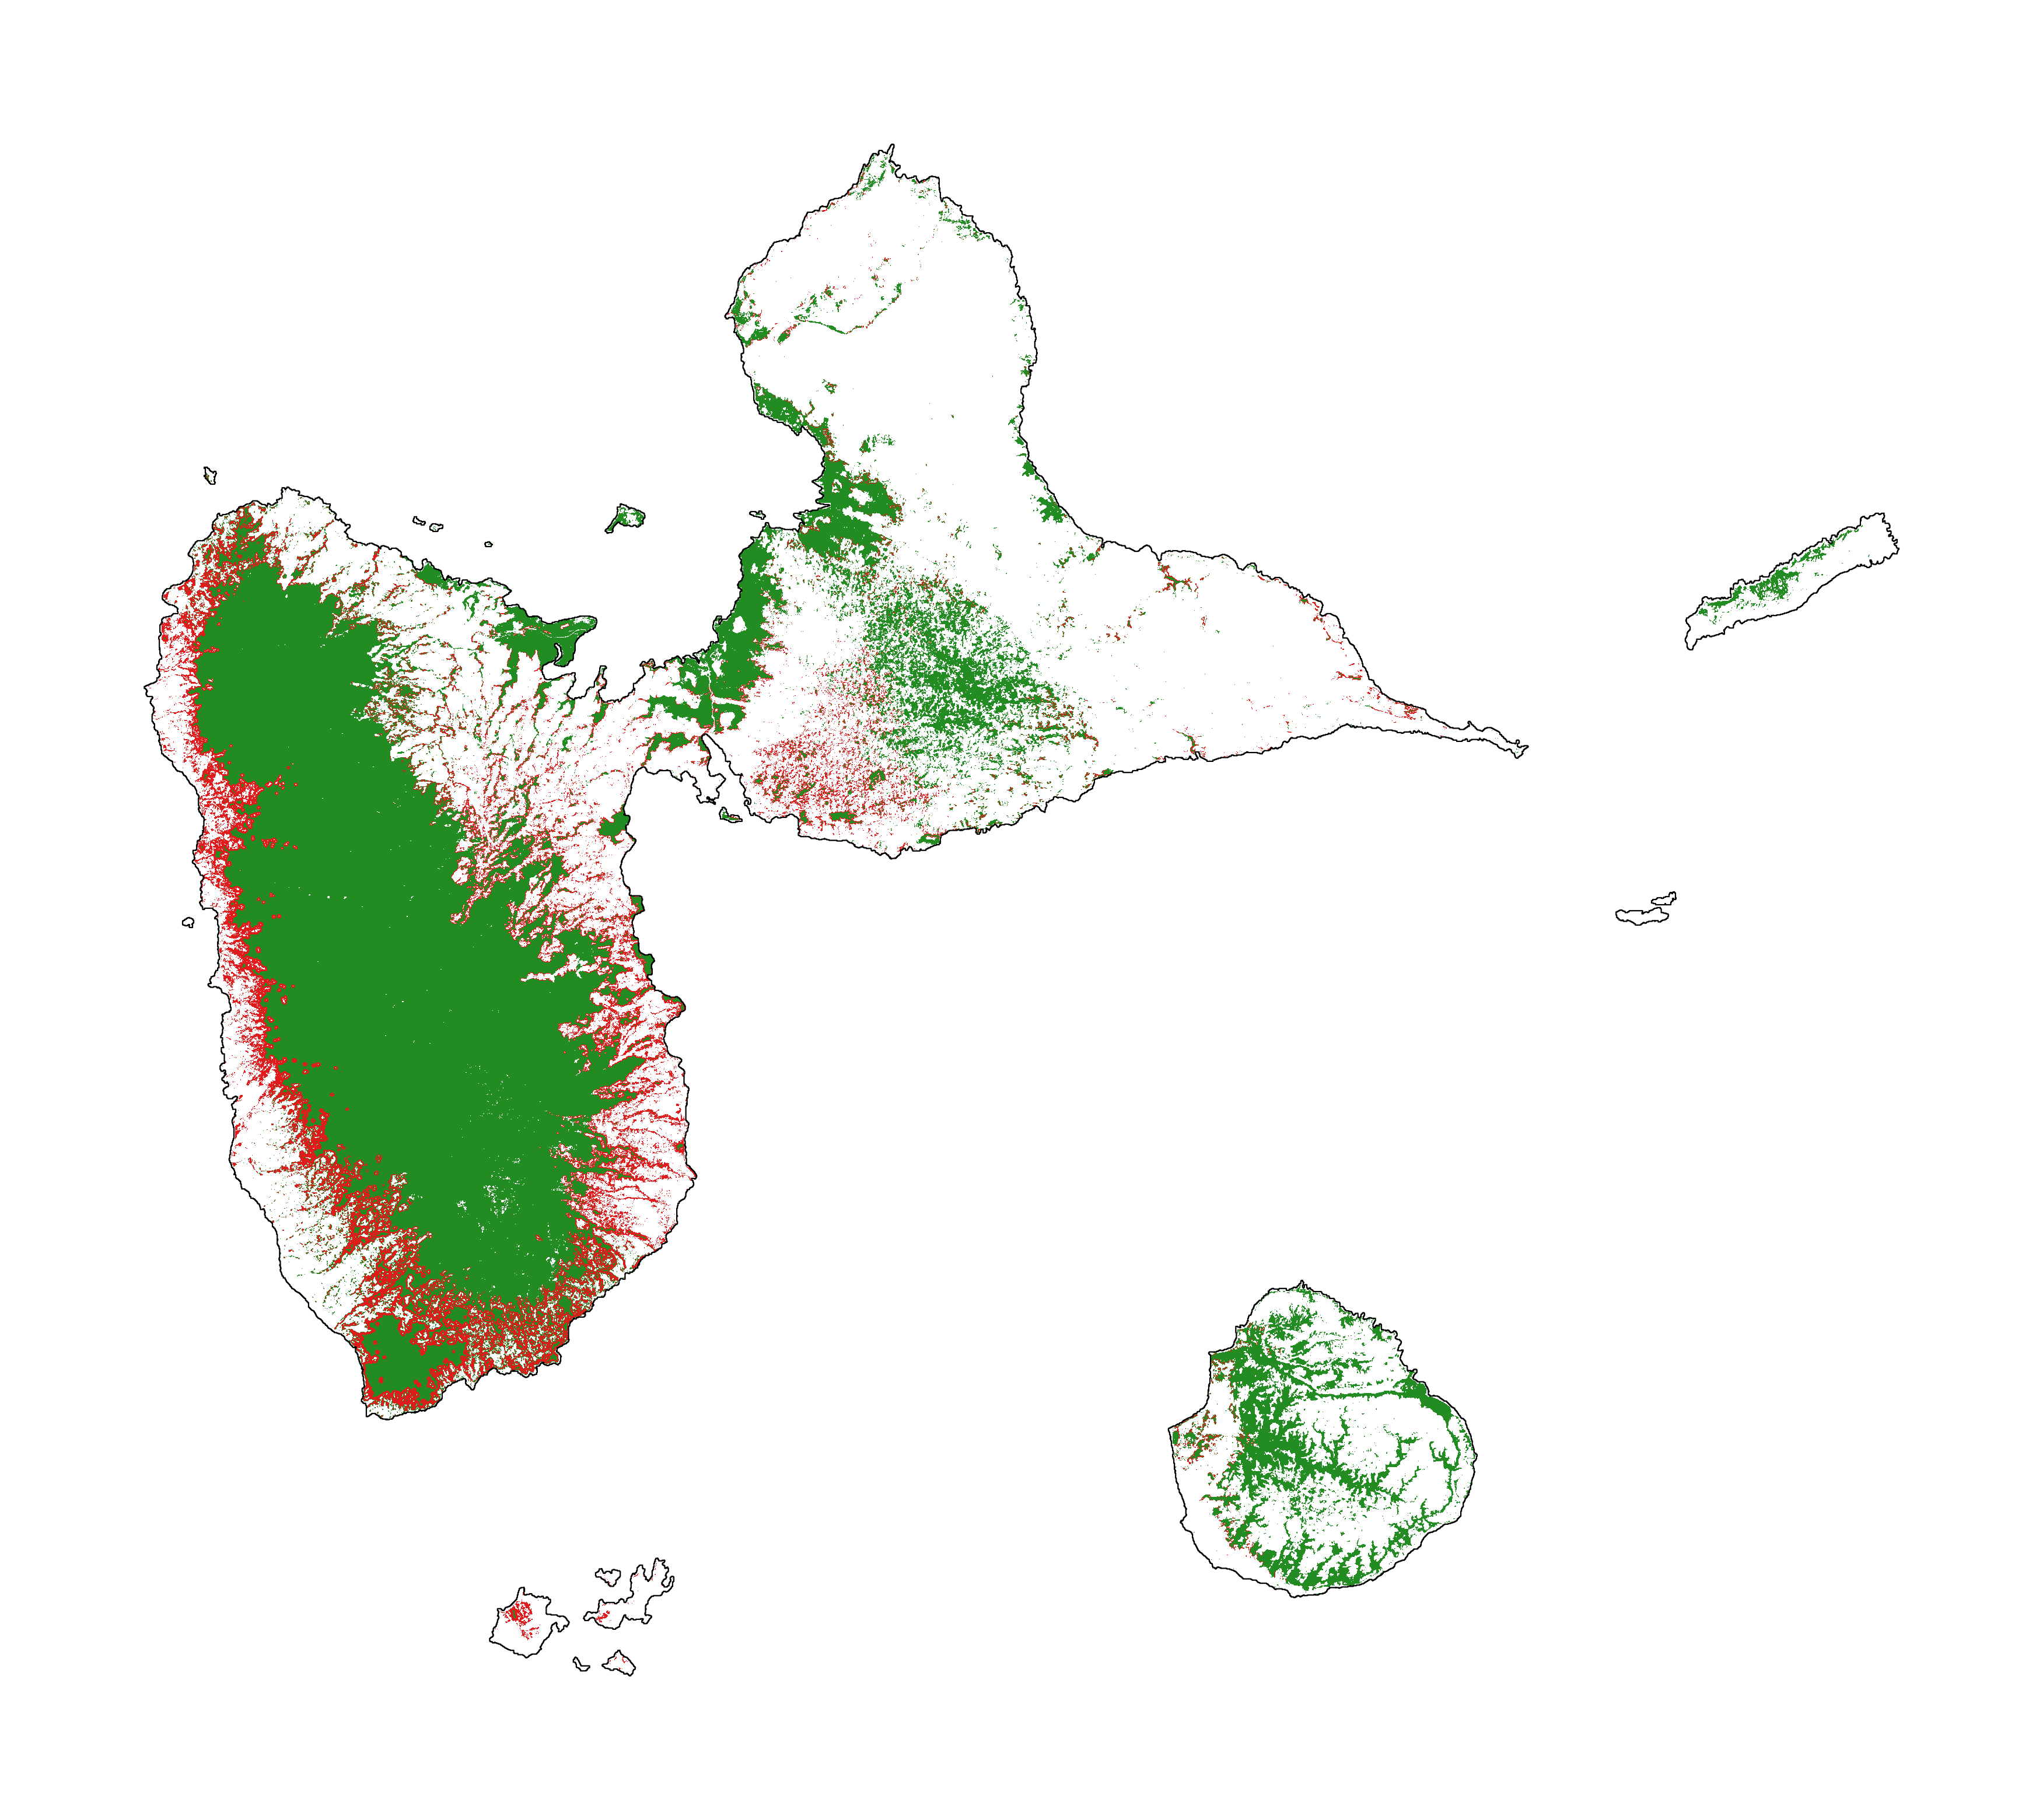

In [16]:
# Projected forest cover change (2020-2050)
fcc_2050 = far.plot.fcc("output/fcc_2050.tif",
                        maxpixels=1e8,
                        borders="data/ctry_PROJ.shp",
                        linewidth=0.2,
                        output_file="output/fcc_2050.png",
                        figsize=(5, 4), dpi=800)